In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import logging
import json
import time
from concurrent.futures import ThreadPoolExecutor, as_completed


# NOTE: Usar Docker
# NOTE: Garantir que usei todas as bibliotecas
# NOTE: Limpar prints no final do código

'''
Tarefa 1: Extração de Dados
1. Consumo de Dados:

Acesse a PokeAPI na rota /pokemon?limit=100&offset=0 para obter uma lista de 100 Pokémon.
Para cada Pokémon, obtenha detalhes adicionais consultando a rota /pokemon/{id}.

2. Estruturação com pandas:
Construa um DataFrame com as seguintes colunas:

ID: Identificador único do Pokémon.
Nome: Nome do Pokémon (normalizado para título, ex.: "PIKACHU" → "Pikachu").
Experiência Base: Valor do campo base_experience.
Tipos: Lista de types do Pokémon (ex.: ["Eletric", "Flying"]).
HP: Valor da estatística "HP".
Ataque: Valor da estatística "Attack".
Defesa: Valor da estatística "Defense".'''

def get_pokemon_data(pokemon_url):
    try:
        response = requests.get(pokemon_url)
        pokemon_data = response.json()

        id = pokemon_data.get('id')
        name = pokemon_data.get('name').capitalize()
        xp = pokemon_data.get('base_experience')

        types = []
        for pokemon_type in pokemon_data['types']:
            types.append(pokemon_type['type']['name'])

        hp = None
        attack = None
        defense = None
        for pokemon_stat in pokemon_data['stats']:
            if pokemon_stat['stat']['name'] == 'hp':
                hp = pokemon_stat['base_stat']

            elif pokemon_stat['stat']['name'] == 'attack':
                attack = pokemon_stat['base_stat']

            elif pokemon_stat['stat']['name'] == 'defense':
                defense = pokemon_stat['base_stat']

        return [id,name,xp,types,hp,attack,defense]
    
    except requests.RequestException as e:
        print(f"Erro na requisição {pokemon_url}: {e}")
        return None

# if __name__ == "__main__":
start_time = time.perf_counter()

## Tarefa 1
# Chamada de API
url = "https://pokeapi.co/api/v2/pokemon?limit=100&offset=0"
response = requests.get(url,timeout=15)
pokemon_data = response.json()
pokemons = pokemon_data['results']
urls = [pokemon['url'] for pokemon in pokemons]

pokemon_data = []
operations = []
# Paralelismo de requisições (Threading)
with ThreadPoolExecutor(max_workers=5) as executor:
    for url in urls:
        operation = executor.submit(get_pokemon_data, url)
        operations.append(operation)

    for i, operation in enumerate(as_completed(operations), 1):
        result = operation.result()
        if result:
            pokemon_data.append(result)
            print(f"{i} - {result[1]}")

# Construção do DataFrame
df = pd.DataFrame(pokemon_data, columns=['ID','Nome','Experiência Base','Tipos', 'HP', 'Ataque', 'Defesa']).sort_values(by="ID")

## Tarefa 2
# ADD coluna categoria
df['Categoria'] = df['Experiência Base'].apply(lambda x: 'Fraco' if x < 50 else ('Médio' if x <= 100 else 'Forte'))
print(df)

# Criar DF com contagem dos tipos de pokemon
tipo_dict = {}
for tipos in df['Tipos']:
    for tipo in tipos:
        tipo_dict[tipo] = tipo_dict.get(tipo, 0) + 1

print(tipo_dict)

df_type_count = (pd.DataFrame.from_dict(tipo_dict, orient='index', columns=['Quantidade'])
                    .reset_index()
                    .rename(columns={'index': 'Tipo'})
                    .sort_values(by='Quantidade', ascending=False))
print(df_type_count)

1 - Venusaur
2 - Charmeleon
3 - Charmander
3 - Charmander
4 - Wartortle
5 - Charizard
4 - Wartortle
5 - Charizard
6 - Squirtle
6 - Squirtle
7 - Ivysaur
8 - Caterpie
9 - Metapod
7 - Ivysaur
8 - Caterpie
9 - Metapod
10 - Bulbasaur
10 - Bulbasaur
11 - Butterfree
12 - Weedle
13 - Blastoise
14 - Beedrill
11 - Butterfree
12 - Weedle
13 - Blastoise
14 - Beedrill
15 - Pidgeot
15 - Pidgeot
16 - Raticate
17 - Kakuna
16 - Raticate
17 - Kakuna
18 - Pidgeotto
18 - Pidgeotto
19 - Spearow
19 - Spearow
20 - Rattata
20 - Rattata
21 - Arbok
22 - Pidgey
21 - Arbok
22 - Pidgey
23 - Pikachu
24 - Ekans
23 - Pikachu
24 - Ekans
25 - Sandshrew
25 - Sandshrew
26 - Sandslash
26 - Sandslash
27 - Nidoran-f
28 - Nidorina
27 - Nidoran-f
28 - Nidorina
29 - Raichu
29 - Raichu
30 - Nidoqueen
30 - Nidoqueen
31 - Nidoran-m
32 - Nidorino
31 - Nidoran-m
32 - Nidorino
33 - Clefairy
33 - Clefairy
34 - Nidoking
34 - Nidoking
35 - Fearow
36 - Vulpix
35 - Fearow
36 - Vulpix
37 - Zubat
38 - Wigglytuff
37 - Zubat
38 - Wigglytuff


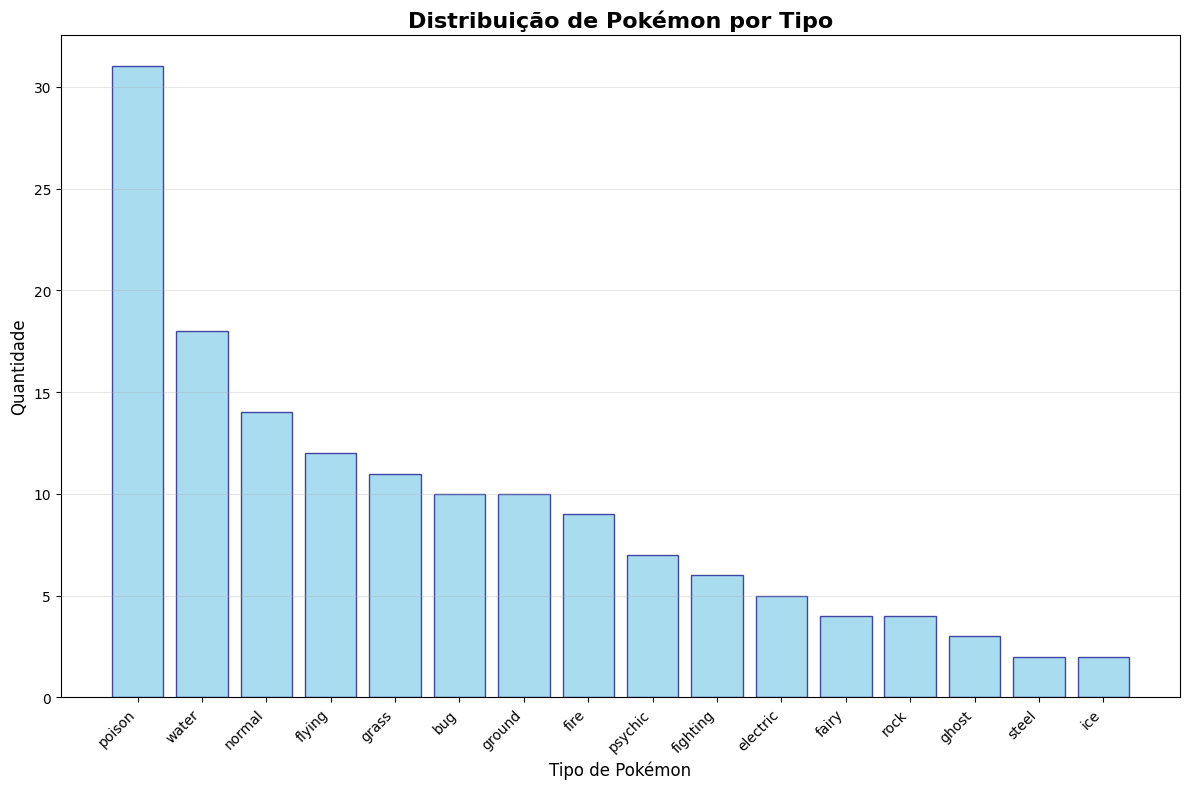

Tempo total: 41.85 segundos


<Figure size 640x480 with 0 Axes>

In [5]:
# Gerar gráfico MatplotLib
plt.figure(figsize=(12, 8))
plt.bar(df_type_count['Tipo'], df_type_count['Quantidade'], color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Distribuição de Pokémon por Tipo', fontsize=16, fontweight='bold')
plt.xlabel('Tipo de Pokémon', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Salvar o gráfico como imagem
plt.savefig('distribuicao_tipos_pokemon.png', dpi=300, bbox_inches='tight')

elapsed = time.perf_counter() - start_time
print(f"Tempo total: {elapsed:.2f} segundos")

In [7]:
df_exploded = df.explode('Tipos')

stats_por_tipo = df_exploded.groupby('Tipos').agg({
    'HP': 'mean',
    'Ataque': 'mean',
    'Defesa': 'mean'
}).round(2).sort_values(by='Tipos', ascending=True)

print("1. Média de HP, Ataque e Defesa por Tipo de Pokémon:")
print(stats_por_tipo)
print()

# 2. Os 5 Pokémon com maior experiência base
top_5_xp = df.nlargest(5, 'Experiência Base')[['Nome', 'Experiência Base', 'Tipos', 'HP', 'Ataque', 'Defesa']]

print("2. Top 5 Pokémon com maior Experiência Base:")
print(top_5_xp.to_string(index=False))
print()

# Estatísticas gerais
print("3. Estatísticas Gerais:")
print(f"Total de Pokémon analisados: {len(df)}")
print(f"Pokémon mais forte (maior XP): {df.loc[df['Experiência Base'].idxmax(), 'Nome']} ({df['Experiência Base'].max()} XP)")
print(f"Pokémon mais fraco (menor XP): {df.loc[df['Experiência Base'].idxmin(), 'Nome']} ({df['Experiência Base'].min()} XP)")
print(f"Experiência Base média: {df['Experiência Base'].mean():.2f}")

1. Média de HP, Ataque e Defesa por Tipo de Pokémon:
              HP  Ataque  Defesa
Tipos                           
bug        53.00   53.00   50.50
electric   42.00   54.00   62.00
fairy     105.00   57.50   46.50
fighting   72.50   98.33   65.00
fire       60.67   75.78   60.44
flying     57.58   72.83   55.67
ghost      45.00   50.00   45.00
grass      59.55   74.82   62.73
ground     55.10   86.40   93.90
ice        70.00   82.50  130.00
normal     63.07   70.50   49.29
poison     61.06   67.26   56.23
psychic    64.29   52.29   54.29
rock       52.50   85.00  126.25
steel      37.50   47.50   82.50
water      62.89   72.11   81.44

2. Top 5 Pokémon com maior Experiência Base:
     Nome  Experiência Base             Tipos  HP  Ataque  Defesa
Charizard               240    [fire, flying]  78      84      78
Blastoise               239           [water]  79      83     100
 Venusaur               236   [grass, poison]  80      82      83
Poliwrath               230 [water, fightin

In [3]:

'''
Tarefa 2: Transformação de Dados
1. Categorização:
Adicione uma coluna chamada Categoria que classifique os Pokémon em:
"Fraco": Experiência base < 50.
"Médio": Experiência base entre 50 e 100.
"Forte": Experiência base > 100.

2. Transformações de Tipos:
Crie um novo DataFrame que contenha a contagem de Pokémon por tipo.
Gere um gráfico de barras com matplotlib ou seaborn mostrando a distribuição de Pokémon por tipo.

3. Análise Estatística:
Calcule e exiba:
A média de ataque, defesa e HP por tipo de Pokémon.
Os 5 Pokémon com maior experiência base.'''

'''
Tarefa 3: Relatório e Exportação

1. Relatório com pandas:
Gere um relatório consolidado contendo os seguintes elementos:
Tabela dos 5 Pokémon com maior experiência base.
Tabela com a média de ataque, defesa e HP por tipo.
Gráfico de distribuição de Pokémon por tipo.

2. Exportação:
Salve o relatório em formato CSV e o gráfico gerado como uma imagem (.png).'''


'''
Tarefa 4: Pipeline Automatizado
1. Automatize o Processo:
Crie um script Python modular que execute as tarefas acima em sequência:
Extração dos dados.
Transformação e categorização.
Geração e exportação do relatório.

2. Logs e Erros:
Implemente logs utilizando a biblioteca logging para acompanhar o progresso do pipeline.
Garanta o tratamento adequado de erros, como falhas na API ou dados faltantes.'''

'\nTarefa 4: Pipeline Automatizado\n1. Automatize o Processo:\nCrie um script Python modular que execute as tarefas acima em sequência:\nExtração dos dados.\nTransformação e categorização.\nGeração e exportação do relatório.\n\n2. Logs e Erros:\nImplemente logs utilizando a biblioteca logging para acompanhar o progresso do pipeline.\nGaranta o tratamento adequado de erros, como falhas na API ou dados faltantes.'